## Timeseries Dataset Explorer

Achievements now have completion dates for each user and a tally of how many achievements each player completed for every month from Jan 2010 to may 2020.

## Set up timeseries dataframe
Arrange the data so that rows = date, columns = achievements per month, index = player_realm

In [2]:
import os
import pandas as pd
import datetime as dt
import subscript.config as cn
from IPython.display import HTML
import numpy as np
import seaborn as sns
import subscript.custom_funcs as cf

file_in = os.path.join(os.path.join(cn.clean_dir, 'random_forest_time','final_time_stats.csv'))
player_cols = ['player', 'realm', 'last_login', 'time_since_login', 'status','gear_score', '2020-05']
dfa_dates = cf.get_dates()
keep_cols = player_cols + dfa_dates[-74:]
keep_cols.append('engagement')
df = pd.read_csv(file_in)
extra_cols = [col for col in df.columns.values if 'unnamed' in col.lower() or  col not in keep_cols]
df = df.drop(extra_cols, axis = 1)
df = df.drop_duplicates()


df_original = df.copy()
display(HTML(df.head().to_html()))



/Users/haleyspeed/Docs/insight/ins_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


,player,realm,gear_score,last_login,time_since_login,2015-01,2016-01,2017-01,2018-01,2019-01,2020-01,2015-02,2016-02,2017-02,2018-02,2019-02,2020-02,2015-03,2016-03,2017-03,2018-03,2019-03,2020-03,2014-04,2015-04,2016-04,2017-04,2018-04,2019-04,2020-04,2014-05,2015-05,2016-05,2017-05,2018-05,2019-05,2020-05,2014-06,2015-06,2016-06,2017-06,2018-06,2019-06,2014-07,2015-07,2016-07,2017-07,2018-07,2019-07,2014-08,2015-08,2016-08,2017-08,2018-08,2019-08,2014-09,2015-09,2016-09,2017-09,2018-09,2019-09,2014-10,2015-10,2016-10,2017-10,2018-10,2019-10,2014-11,2015-11,2016-11,2017-11,2018-11,2019-11,2014-12,2015-12,2016-12,2017-12,2018-12,2019-12,engagement,status
0,runeknight,whisperwind,437.0,2020-05-31,5 days 00:00:00.000000000,0.0,4.0,0.0,5.0,8.0,3.0,1.0,3.0,2.0,1.0,20.0,4.0,6.0,14.0,2.0,3.0,2.0,7.0,0.0,0.0,7.0,0.0,0.0,3.0,15.0,0.0,0.0,13.0,4.0,0.0,0.0,13.0,1.0,2.0,2.0,6.0,1.0,2.0,1.0,0.0,4.0,2.0,1.0,5.0,0.0,1.0,1.0,3.0,1.0,0.0,2.0,1.0,30.0,7.0,1.0,3.0,9.0,1.0,3.0,0.0,1.0,0.0,0.0,39.0,2.0,7.0,17.0,1.0,7.0,7.0,0.0,1.0,2.0,3.0,0.0,active
1,chrichton,whisperwind,451.0,2020-06-04,1 days 00:00:00.000000000,4.0,1.0,1.0,6.0,5.0,1.0,1.0,1.0,0.0,2.0,18.0,0.0,4.0,2.0,0.0,3.0,2.0,4.0,0.0,5.0,5.0,10.0,1.0,3.0,21.0,0.0,0.0,5.0,15.0,0.0,0.0,13.0,2.0,4.0,1.0,1.0,2.0,2.0,1.0,18.0,3.0,2.0,1.0,16.0,0.0,2.0,1.0,6.0,5.0,2.0,2.0,5.0,2.0,3.0,4.0,3.0,8.0,1.0,20.0,6.0,4.0,3.0,37.0,15.0,69.0,4.0,16.0,1.0,23.0,6.0,7.0,2.0,1.0,3.0,0.0,active
2,shìfted,whisperwind,447.0,2020-06-07,-2 days +00:00:00.000000000,10.0,1.0,0.0,6.0,8.0,1.0,2.0,1.0,0.0,2.0,19.0,0.0,4.0,8.0,0.0,32.0,2.0,4.0,5.0,0.0,4.0,0.0,0.0,4.0,14.0,3.0,0.0,5.0,38.0,0.0,0.0,12.0,7.0,7.0,1.0,7.0,2.0,3.0,4.0,3.0,3.0,2.0,1.0,6.0,1.0,3.0,7.0,4.0,29.0,0.0,2.0,4.0,24.0,3.0,7.0,3.0,8.0,1.0,6.0,7.0,8.0,6.0,11.0,16.0,3.0,7.0,17.0,3.0,53.0,16.0,1.0,0.0,3.0,48.0,0.0,active
3,láwdamercy,whisperwind,329.0,2020-06-07,-2 days +00:00:00.000000000,7.0,0.0,0.0,10.0,5.0,1.0,1.0,1.0,0.0,2.0,18.0,0.0,4.0,2.0,0.0,9.0,2.0,4.0,1.0,0.0,4.0,0.0,10.0,3.0,12.0,0.0,0.0,5.0,3.0,8.0,1.0,12.0,1.0,2.0,1.0,1.0,5.0,2.0,1.0,13.0,3.0,0.0,1.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,2.0,4.0,0.0,15.0,2.0,3.0,8.0,1.0,3.0,3.0,5.0,0.0,1.0,16.0,11.0,4.0,16.0,2.0,21.0,10.0,2.0,0.0,2.0,10.0,0.0,active
4,portsforsale,whisperwind,268.0,2019-10-23,226 days 00:00:00.000000000,10.0,2.0,6.0,1.0,5.0,1.0,65.0,9.0,12.0,6.0,18.0,0.0,49.0,22.0,17.0,5.0,5.0,4.0,0.0,15.0,8.0,13.0,2.0,3.0,10.0,16.0,7.0,4.0,15.0,1.0,1.0,12.0,0.0,6.0,13.0,9.0,1.0,2.0,11.0,6.0,16.0,5.0,1.0,3.0,3.0,3.0,14.0,7.0,4.0,1.0,75.0,6.0,36.0,6.0,1.0,3.0,5.0,15.0,21.0,1.0,5.0,1.0,47.0,9.0,13.0,1.0,16.0,1.0,19.0,4.0,7.0,0.0,4.0,1.0,1.0,risk


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154799 entries, 0 to 169453
Data columns (total 81 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   player            154799 non-null  object 
 1   realm             154799 non-null  object 
 2   gear_score        154799 non-null  float64
 3   last_login        154799 non-null  object 
 4   time_since_login  154799 non-null  object 
 5   2015-01           154799 non-null  float64
 6   2016-01           154799 non-null  float64
 7   2017-01           154799 non-null  float64
 8   2018-01           154799 non-null  float64
 9   2019-01           154799 non-null  float64
 10  2020-01           154799 non-null  float64
 11  2015-02           154799 non-null  float64
 12  2016-02           154799 non-null  float64
 13  2017-02           154799 non-null  float64
 14  2018-02           154799 non-null  float64
 15  2019-02           154799 non-null  float64
 16  2020-02           15

In [4]:
df = df.drop(['player', 'realm', 'last_login', 'time_since_login', 'status'], axis = 1)
df.describe().to_csv(os.path.join(cn.clean_dir, 'eda', 'time_series_descriptive_stats.csv'))
df.describe()

,gear_score,2015-01,2016-01,2017-01,2018-01,2019-01,2020-01,2015-02,2016-02,2017-02,...,2017-11,2018-11,2019-11,2014-12,2015-12,2016-12,2017-12,2018-12,2019-12,engagement
count,154799.000000,154799.000000,154799.000000,154799.000000,154799.000000,154799.000000,154799.000000,154799.000000,154799.000000,154799.000000,...,154799.000000,154799.000000,154799.000000,154799.000000,154799.000000,154799.000000,154799.000000,154799.000000,154799.000000,154799.000000
mean,424.153974,7.201461,5.427419,7.045872,6.563744,8.990342,9.788086,5.375668,4.514680,5.484047,...,5.726562,7.671251,7.799224,10.280648,6.816840,6.144219,6.579590,8.733177,7.264866,0.340106
std,52.571612,13.873451,14.038837,14.178098,13.689676,14.450055,16.969488,11.152394,12.076785,12.788810,...,13.145791,13.510488,16.254866,17.314673,13.788882,13.311129,14.209364,13.330882,15.096494,0.549881
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,401.000000,1.000000,0.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,2.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,1.000000,0.000000
50%,438.000000,3.000000,2.000000,2.000000,3.000000,5.000000,4.000000,2.000000,1.000000,1.000000,...,2.000000,4.000000,3.000000,4.000000,3.000000,2.000000,2.000000,4.000000,3.000000,0.000000
75%,464.000000,7.000000,5.000000,7.000000,6.000000,10.000000,11.000000,6.000000,4.000000,5.000000,...,6.000000,8.000000,7.000000,12.000000,6.000000,6.000000,7.000000,10.000000,7.000000,1.000000
max,486.000000,413.000000,401.000000,425.000000,413.000000,368.000000,342.000000,336.000000,393.000000,321.000000,...,374.000000,466.000000,347.000000,402.000000,372.000000,496.000000,346.000000,304.000000,486.000000,2.000000


## Transpose Data so the x = time and y = player achievements/month

In [5]:
#df.index = [float(str(i).replace('-','')) for i in df.index.values] 

df_m = df.groupby('engagement').mean()
display(HTML(df_m.head().to_html()))

,gear_score,2015-01,2016-01,2017-01,2018-01,2019-01,2020-01,2015-02,2016-02,2017-02,2018-02,2019-02,2020-02,2015-03,2016-03,2017-03,2018-03,2019-03,2020-03,2014-04,2015-04,2016-04,2017-04,2018-04,2019-04,2020-04,2014-05,2015-05,2016-05,2017-05,2018-05,2019-05,2020-05,2014-06,2015-06,2016-06,2017-06,2018-06,2019-06,2014-07,2015-07,2016-07,2017-07,2018-07,2019-07,2014-08,2015-08,2016-08,2017-08,2018-08,2019-08,2014-09,2015-09,2016-09,2017-09,2018-09,2019-09,2014-10,2015-10,2016-10,2017-10,2018-10,2019-10,2014-11,2015-11,2016-11,2017-11,2018-11,2019-11,2014-12,2015-12,2016-12,2017-12,2018-12,2019-12
engagement,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,437.129124,7.498100,5.576542,7.347485,6.806605,9.113077,10.661610,5.623453,4.713208,5.666667,6.386918,6.941987,10.213647,4.982668,4.150162,6.038370,5.508915,7.417413,12.430040,3.749859,4.375669,3.904874,7.512252,5.007524,6.286894,18.929628,3.151798,4.097326,4.124280,6.388407,4.925940,6.588346,20.581219,3.510561,5.679136,4.562001,7.511448,5.665031,8.022813,3.449128,6.366925,7.150883,6.067247,7.869508,11.960511,3.996044,5.688066,10.817670,5.501169,20.794311,8.328721,4.074614,4.745607,13.465350,6.835732,15.020049,5.346505,6.170064,4.351765,9.408724,5.366111,10.637808,5.811819,15.575257,5.607729,7.450736,5.954161,7.795975,8.104989,10.662100,7.055905,6.357894,6.803980,8.940333,7.706118
1.0,395.954662,6.433668,5.014907,6.222871,5.941800,8.621920,8.244727,4.773014,4.018012,4.985659,6.091440,6.371427,7.824340,4.308644,3.574832,4.998571,5.287650,6.945841,8.360019,3.202469,3.766854,3.343066,6.419771,5.113345,5.903262,9.745737,2.692095,3.535383,3.376774,5.506850,4.514513,6.255544,9.150429,3.125049,4.797359,4.031293,6.410236,5.303864,7.011236,2.975532,5.221516,6.375961,5.072689,7.898901,9.386113,3.572319,4.571826,9.750049,4.739479,18.632885,7.085403,3.485832,3.921693,10.899320,5.903238,14.303026,4.404987,5.353735,3.395993,8.145772,4.784915,10.368347,5.162478,12.840011,4.855091,6.609378,5.128967,7.198379,7.683841,9.291617,6.242066,5.560147,5.984994,8.040114,6.716218
2.0,381.174901,7.047082,5.528349,7.173740,6.392573,9.267905,4.505471,4.986406,4.295756,5.562003,5.741545,7.264257,4.826094,4.706731,3.665119,5.463362,5.018402,7.620524,5.500995,3.457891,4.259284,3.516412,6.866214,4.605603,6.526691,7.393568,2.603946,4.157493,3.737898,5.980106,4.275862,7.832228,9.017241,2.983256,5.264920,4.178382,6.788130,6.425066,8.976956,3.013428,5.289788,6.734582,5.483588,9.679045,11.955902,3.589357,4.720325,10.843667,5.633786,25.823773,8.506797,3.753150,3.879476,13.234251,6.235245,19.103282,3.303050,5.634781,3.483588,9.678548,4.891578,12.545922,2.451592,14.205902,4.788130,7.929045,5.665285,8.615882,3.091678,10.093667,6.396386,6.241711,6.555703,9.680869,3.042440


## Get mean achievements per month

In [6]:
dft = df_m.T.reset_index()
dft = dft.iloc[1:][:]
dft.columns.values[0] = 'dates'
dft.dates = pd.to_datetime(dft.dates)
dft = dft.sort_values('dates')
dft = dft.set_index('dates')
dft.columns = ['active','risk','lapsed']
#dft = dft.astype(float).diff(baseline)
dft.to_csv(os.path.join(cn.clean_dir, 'eda', 'time_series_plot_data.csv'))
display(HTML(dft.to_html()))

,active,risk,lapsed
dates,,,
2014-04-01,3.749859,3.202469,3.457891
2014-05-01,3.151798,2.692095,2.603946
2014-06-01,3.510561,3.125049,2.983256
2014-07-01,3.449128,2.975532,3.013428
2014-08-01,3.996044,3.572319,3.589357
2014-09-01,4.074614,3.485832,3.753150
2014-10-01,6.170064,5.353735,5.634781
2014-11-01,15.575257,12.840011,14.205902
2014-12-01,10.662100,9.291617,10.093667


## Plot mean achievements per month

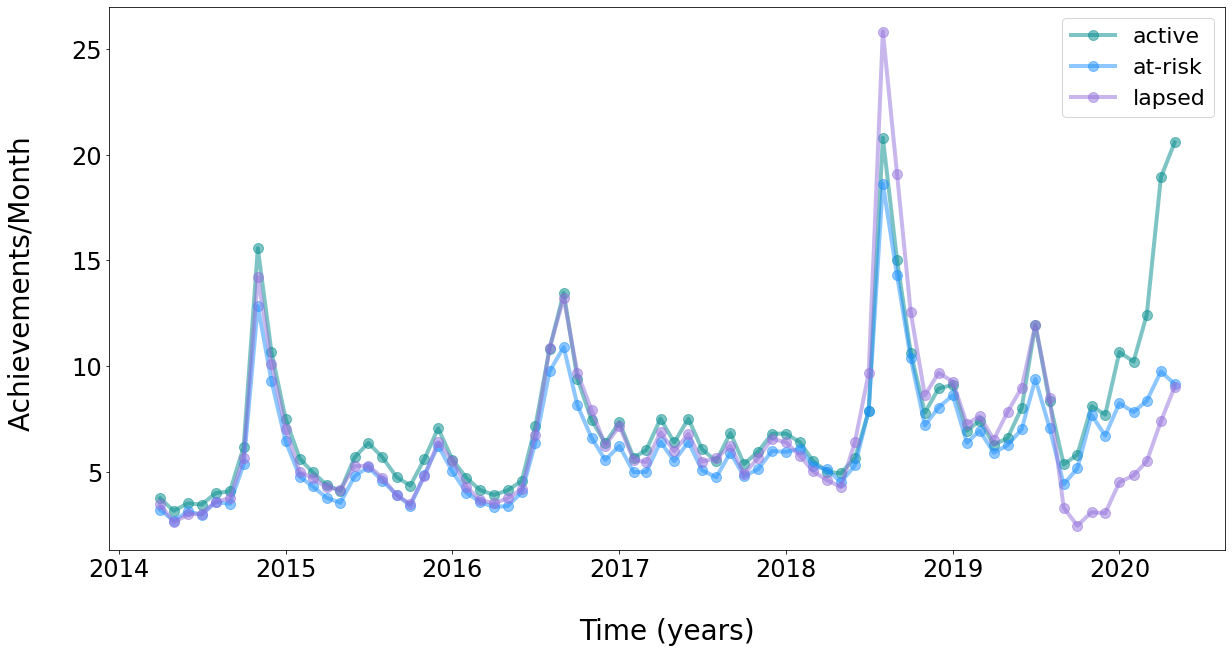

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import datetime as dt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(20, 10))
a = ax.plot_date(sorted(dft.index), dft.active, label = 'active',   fmt = '-4', 
                 color = 'darkcyan', alpha = 0.5, linewidth=4,marker = 'o', 
                 markersize=10)
a = ax.plot_date(sorted(dft.index), dft.risk, label = 'at-risk',   fmt = '-4', 
                 color = 'dodgerblue', alpha = 0.5, linewidth=4,marker = 'o', 
                 markersize=10)
a = ax.plot_date(sorted(dft.index), dft.lapsed, label = 'lapsed',   fmt = '-4', 
                 color = 'mediumpurple', alpha = 0.5, linewidth=4,marker = 'o', 
                 markersize=10)


a = ax.set_xlabel('\nTime (years)', fontsize = 28, color = 'black')
a = ax.set_ylabel('Achievements/Month \n', fontsize = 28, color = 'black')
a = ax.tick_params(labelsize = 24, labelcolor = 'black')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize = 22)

In [13]:
df.corr()

,gear_score,2015-01,2016-01,2017-01,2018-01,2019-01,2020-01,2015-02,2016-02,2017-02,...,2017-11,2018-11,2019-11,2014-12,2015-12,2016-12,2017-12,2018-12,2019-12,engagement
gear_score,1.000000,0.058156,0.038974,0.094677,0.056467,0.107669,0.216528,0.066281,0.043583,0.067096,...,0.058233,0.067910,0.096624,0.087191,0.036311,0.072614,0.069022,0.114852,0.103438,-0.371613
2015-01,0.058156,1.000000,0.069633,0.093616,0.011176,0.019982,-0.003660,0.468177,0.064460,0.057918,...,0.030194,0.015234,-0.030255,0.474964,0.099227,0.077183,0.031693,0.031666,-0.028474,-0.027964
2016-01,0.038974,0.069633,1.000000,0.081276,0.028700,0.012883,0.002025,0.066893,0.414217,0.054124,...,0.035346,0.012837,-0.016083,0.071881,0.386453,0.079132,0.042665,0.028282,-0.018410,-0.012991
2017-01,0.094677,0.093616,0.081276,1.000000,0.044239,0.046252,0.015530,0.093009,0.092375,0.423464,...,0.071956,0.021489,-0.035074,0.122217,0.085168,0.478666,0.081244,0.058872,-0.039804,-0.026398
2018-01,0.056467,0.011176,0.028700,0.044239,1.000000,0.049180,0.002264,0.017070,0.035652,0.044751,...,0.203102,0.049974,-0.014704,0.020522,0.031740,0.043610,0.421642,0.065412,-0.018886,-0.023433
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12,0.072614,0.077183,0.079132,0.478666,0.043610,0.039434,-0.003546,0.082153,0.086498,0.242197,...,0.069253,0.027113,-0.030609,0.092424,0.078232,1.000000,0.075025,0.052121,-0.031984,-0.019882
2017-12,0.069022,0.031693,0.042665,0.081244,0.421642,0.052351,0.013048,0.043578,0.040007,0.074486,...,0.418757,0.040521,-0.017354,0.039610,0.042062,0.075025,1.000000,0.067722,-0.025966,-0.020189
2018-12,0.114852,0.031666,0.028282,0.058872,0.065412,0.434510,0.026193,0.036291,0.029686,0.045817,...,0.052294,0.409144,-0.026058,0.037111,0.023784,0.052121,0.067722,1.000000,-0.016451,-0.014712
2019-12,0.103438,-0.028474,-0.018410,-0.039804,-0.018886,-0.020715,0.338270,-0.033213,-0.013711,-0.033644,...,-0.017979,-0.013287,0.348660,-0.043652,-0.021934,-0.031984,-0.025966,-0.016451,1.000000,-0.056968


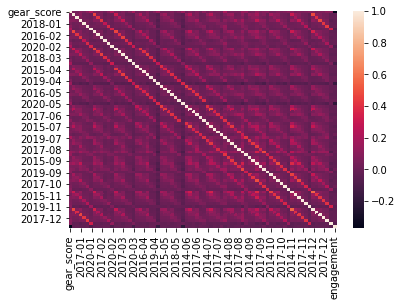

In [14]:
sns.heatmap(df.corr())

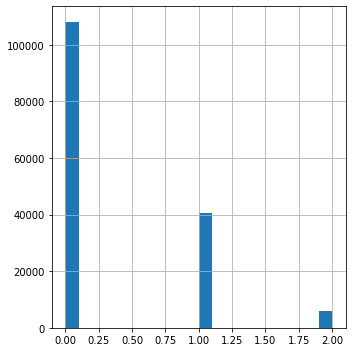

In [15]:
h = df.engagement.hist(bins = 20, figsize = (5,5))
plt.tight_layout()

## Stratified Shuffle Split

In [16]:
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

y = df.engagement
X = df.drop('engagement', axis = 1)

split = StratifiedShuffleSplit(n_splits = 10, test_size = 0.25, random_state = 17)
for train_index, test_index in split.split(df, df.engagement):
    strat_train = df.iloc[train_index][:]
    strat_test = df.iloc[test_index][:]
    whole_training_set = df_original.iloc[train_index][:]
    whole_test_set = df_original.iloc[test_index][:]
    whole_training_set.to_csv(os.path.join(cn.clean_dir,'random_forest_time',
            'whole_training_set.csv'), index = False)
    whole_test_set.to_csv(os.path.join(cn.clean_dir, 'random_forest_time',
            'whole_test_set.csv'), index = False)

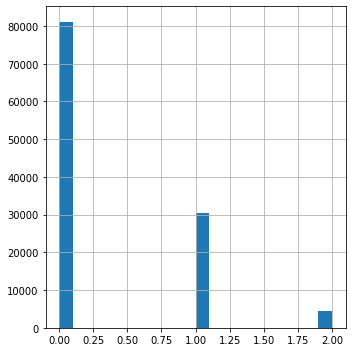

In [17]:
h = strat_train.engagement.hist(bins = 20, figsize = (5,5))
plt.tight_layout()

## Shuffle Split

In [18]:
from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits = 10, test_size = 0.25, random_state = 17)
for train_index, test_index in split.split(df, df.engagement):
    shuff_train = df.iloc[train_index][:]
    shuff_test = df.iloc[test_index][:]

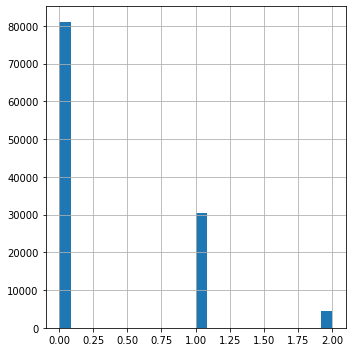

In [19]:
h2 = shuff_train.engagement.hist(bins = 24, figsize = (5,5))
plt.tight_layout()

## Compare ShuffleSplit vs Stratified Shuffle Split

,overall,stratified,shuffled,shuff_p_err,strat_p_err
0.0,0.698861,0.698863,0.699302,-0.063134,-0.000278
1.0,0.262172,0.262171,0.261111,0.404744,0.000646
2.0,0.038967,0.038966,0.039587,-1.590856,0.000646


Text(0.5, 1.0, '% err from overall')

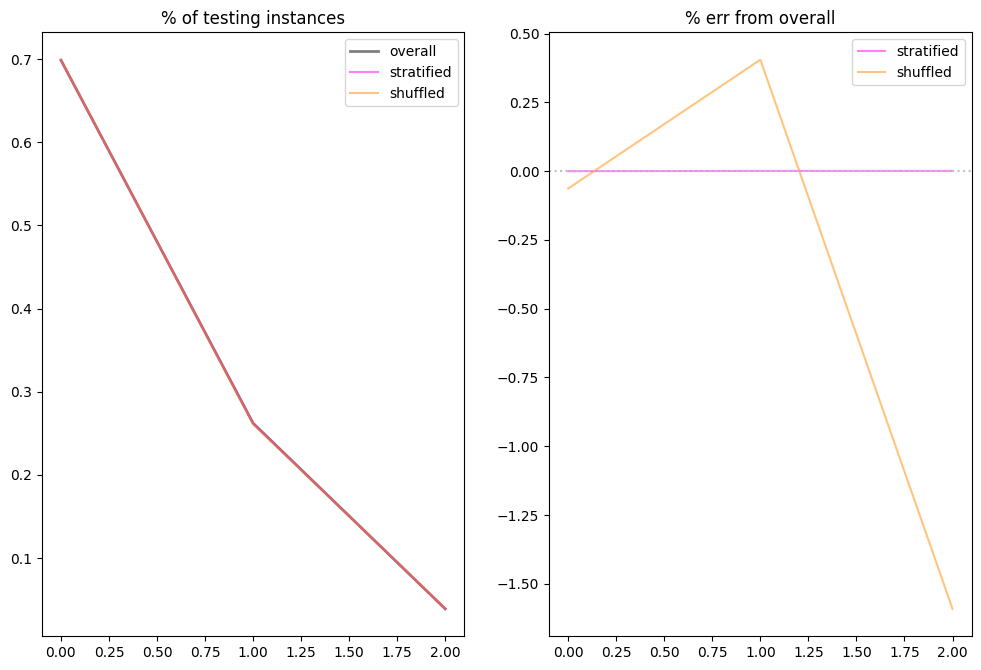

In [20]:
t = pd.DataFrame()
t['overall'] = df.engagement.value_counts()/len(df.index.values)
t['stratified'] = strat_test.engagement.value_counts()/len(strat_test.index.values)
t['shuffled'] = shuff_test.engagement.value_counts()/len(shuff_test.index.values)
t['shuff_p_err'] = 100 * (t.overall - t.shuffled)/ t.overall
t['strat_p_err'] = 100 * (t.overall - t.stratified)/ t.overall
t = t.sort_index()
display(HTML(t.to_html()))

fig, ax = plt.subplots(1,2, figsize = (12,8), dpi = 100)
ax[0].plot(t.index.values, t['overall'], alpha = 0.5, label = 'overall', color = 'black', lw = 2)
ax[0].plot(t.index.values, t['stratified'], alpha = 0.5, label = 'stratified', color = 'magenta')
ax[0].plot(t.index.values, t['shuffled'], alpha = 0.5, label = 'shuffled', color = 'darkorange')
handles, labels = ax[0].get_legend_handles_labels()
sampling_plot0 = ax[0].legend(handles, labels)
ax[0].set_title ('% of testing instances')
    
ax[1].plot(t.index.values, t['strat_p_err'], alpha = 0.5, label = 'stratified', color = 'magenta')
ax[1].plot(t.index.values, t['shuff_p_err'], alpha = 0.5, label = 'shuffled', color = 'darkorange')
handles, labels = ax[1].get_legend_handles_labels()
sampling_plot1 = ax[1].legend(handles, labels)
ax[1].axhline(0, ls = ':', color = 'silver')
ax[1].set_title ('% err from overall')


## Stratified is the clear winner with the lowest error

In [21]:
strat_train.to_csv(os.path.join(cn.clean_dir,'random_forest_time',
        'time_stratified_train.csv'), index = False)
strat_test.to_csv(os.path.join(cn.clean_dir,'random_forest_time',
        'time_stratified_test.csv'), index = False)
strat_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 116099 entries, 139773 to 114714
Data columns (total 76 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   gear_score  116099 non-null  float64
 1   2015-01     116099 non-null  float64
 2   2016-01     116099 non-null  float64
 3   2017-01     116099 non-null  float64
 4   2018-01     116099 non-null  float64
 5   2019-01     116099 non-null  float64
 6   2020-01     116099 non-null  float64
 7   2015-02     116099 non-null  float64
 8   2016-02     116099 non-null  float64
 9   2017-02     116099 non-null  float64
 10  2018-02     116099 non-null  float64
 11  2019-02     116099 non-null  float64
 12  2020-02     116099 non-null  float64
 13  2015-03     116099 non-null  float64
 14  2016-03     116099 non-null  float64
 15  2017-03     116099 non-null  float64
 16  2018-03     116099 non-null  float64
 17  2019-03     116099 non-null  float64
 18  2020-03     116099 non-null  float64
 1